# Curate GO Terms

This notebook is a partner notebook of PeaksToGene. It takes the correlated genes for each peak set, runs GO enrichment and then curates the output. The output is fed back to the PeaksToGene notebook for plotting.

Inspired by `20200416_cicero/PeaksSetsGenesGO.ipynb`

In [2]:
library(gprofiler2)
library(Matrix)
library(ggplot2)
library(patchwork)
library(parallel)
library(reshape2)
library(scales)

### Peak-> Gene Links

In [3]:
p2g_df = read.table("../../analysis/20200925_Peak2Gene/peak2gene_links/RNA_20210725_n59378_ATAC_20210717_n62599/20210826_all_fdr1e-4.tsv", 
                    sep='\t',
                   header=T)
# keep high corr
p2g_df = p2g_df[abs(p2g_df$Correlation)>0.45, ]

dim(p2g_df)
head(p2g_df)

[1] 156016      6

,peak,gene,Correlation,FDR,VarQATAC,VarQRNA
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
6,chr1:906705-907205,LINC01128,0.5794615,1.330099e-44,0.9578667,0.4633998
13,chr1:938013-938513,LINC01128,0.4854523,1.111231e-29,0.9270705,0.4633998
19,chr1:998731-999231,LINC01128,0.5677101,1.820662e-42,0.9439886,0.4633998
23,chr1:1066642-1067142,LINC01128,0.4513822,2.463342e-25,0.7876495,0.4633998
52,chr1:940711-941211,LINC02593,0.4637963,7.331539e-27,0.8949690,0.2648434
53,chr1:941520-942020,LINC02593,0.4999406,1.102645e-31,0.9715865,0.2648434


### Peak Sets

In [4]:
BASE_PATH = "../../analysis/20200307_fine_clustering/beds/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/"
list.files(BASE_PATH)

[1] "all_peaks.bed" "idx1.bed"      "idx10.bed"     "idx11.bed"    
 [5] "idx12.bed"     "idx13.bed"     "idx14.bed"     "idx15.bed"    
 [9] "idx16.bed"     "idx17.bed"     "idx18.bed"     "idx19.bed"    
[13] "idx2.bed"      "idx20.bed"     "idx3.bed"      "idx4.bed"     
[17] "idx5.bed"      "idx6.bed"      "idx7.bed"      "idx8.bed"     
[21] "idx9.bed"      "README.txt"

In [103]:
PEAK_SET_NAMES = paste("idx", seq(1,20), sep='')
PEAK_SET_NAMES

[1] "idx1"  "idx2"  "idx3"  "idx4"  "idx5"  "idx6"  "idx7"  "idx8"  "idx9" 
[10] "idx10" "idx11" "idx12" "idx13" "idx14" "idx15" "idx16" "idx17" "idx18"
[19] "idx19" "idx20"

## Create Gene Sets

In [24]:
gene_tables = list()
gene_lists = list()

# create gene set for each peak set
for (i in seq(length(PEAK_SET_NAMES))) {
    cur_peaks = read.table(sprintf("%s/idx%d.bed", BASE_PATH, i))
    cur_peaks = paste(paste(cur_peaks$V1, cur_peaks$V2, sep=':'), cur_peaks$V3, sep='-')

    gene_lists[[i]] = as.character(p2g_df[p2g_df$peak %in% cur_peaks, "gene"])
    gene_tables[[i]] = rev(sort(table(gene_lists[[i]])))
}

In [25]:
head(gene_tables[[1]], 30)

head(gene_tables[[6]], 30)

head(gene_tables[[17]], 30)
length(gene_tables[[17]])


  COL6A3     MLPH      TNC    FOXF1    CALD1     GNG2    RUNX1    NR3C1 
      37       33       28       27       27       26       25       25 
   FOXL1     DKK3    SMAD3     RXRA   MICAL2    GREM1 TBX2-AS1     TBX2 
      25       25       24       24       24       24       23       23 
   FRMD6   FENDRR   COL5A1   BDKRB1     EGFR   DDX60L CDC42EP3     BPGM 
      23       23       23       23       22       22       22       22 
  ANTXR1    PARVA     NID2     NAV1    HIPK2    FOXC2 
      22       21       21       21       21       21 


    ELOVL4     DNAJC3      COX11      TMED5 NUTM2B-AS1       HPS5       FGL2 
         5          5          5          4          4          4          4 
       APC     ZNF148   SLC25A28     SBSPON    JAKMIP2        FYN      ESRRG 
         4          3          3          3          3          3          3 
    CCDC18       VTA1      VDAC3       TMX4       TMC6     TM9SF3      TFB1M 
         3          2          2          2          2          2          2 
      SYBU   SREK1IP1     SLC9B2    SLC35A3   SERPINB7    SEC23IP        RPE 
         2          2          2          2          2          2          2 
      RFX3     RAET1L 
         2          2 


 KLHDC7A TMEM132D    SMOC2   IGSF21    ADCY2   PCDHB2  PCDHAC1     MYCN 
      28       24       24       21       20       19       18       18 
  MYCNOS    DACT2     XACT  GALNT17    FOXA2   ELAVL2     COBL  PCDHA12 
      16       16       15       15       15       15       15       14 
    KLK8   BCL11B   PCDHB5  PCDHA10    GCNT2   SHISA9     SDK2     RMST 
      14       14       13       13       13       12       12       12 
  PCDHA4    FGFR2  COL23A1    AJAP1 ADAMTS16      SP8 
      12       12       12       12       12       11 

[1] 2220

In [88]:
head(gene_tables[[17]])


 KLHDC7A TMEM132D    SMOC2   IGSF21    ADCY2   PCDHB2 
      28       24       24       21       20       19 

In [85]:
write.table(names(gene_tables[[17]][gene_tables[[17]]>1]), "tmp.txt", row.names =F, quote=F, col.names = F)

## g:Profiler

In [279]:
# sorts gene_table in decreasing order of counts
get_gprof_gost_res <- function(gene_table) {
    gt = names(gene_table)[gene_table>1] # take genes with at least 2 counts
    genes_ordered = names(rev(sort(gene_table)))
    
    gostres = gost(genes_ordered, 
              organism="hsapiens",
              significant=F, # return all
              ordered_query=T)
    
    # compute enrichment (intersection/list_length)/(total_terms/total_genes)
    gostres$result$enrichment = (gostres$result$intersection_size/gostres$result$query_size)/(gostres$result$term_size/gostres$result$effective_domain_size)
    
    gostres
}

In [268]:
gprof_res = mclapply(gene_tables,
                     get_gprof_gost_res,
                     mc.cores=10)

In [287]:
# save all data
saveRDS(gprof_res, "./gprof_results/RNA_20210725_n59378_ATAC_20210717_n62599/gprof.rds")

In [296]:
# save for each peak set
for (i in seq(length(PEAK_SET_NAMES))) {
    filtered = gprof_res[[i]]$result
    filtered = filtered[filtered$significant==TRUE, ]
    filtered = filtered[order(filtered$p_value), ]
    filtered = filtered[, c(-14)] 
    
    write.table(filtered, sprintf("./gprof_results/RNA_20210725_n59378_ATAC_20210717_n62599/per_peak_set/peak_set_%d.tsv", i),
                sep='\t', quote=F, row.names=F)
}

In [347]:
# save for each peak set
for (i in seq(length(PEAK_SET_NAMES))) {    
    write.table(gene_tables[[i]], sprintf("./gprof_results/RNA_20210725_n59378_ATAC_20210717_n62599/gene_sets/idx%d.tsv", i),
                sep='\t', quote=F, row.names=F, col.names=F)
}

In [329]:
gprof_res[[1]]$meta$version

[1] "e104_eg51_p15_3922dba"

In [476]:
filtered = gprof_res[[6]]$result
filtered = filtered[filtered$significant==TRUE, ]
filtered = filtered[filtered$source=="GO:BP", c(4,5,6,12, 9, 10,11,3, 15)]
dim(filtered)
head(filtered[rev(order(filtered$enrichment)), ], 15)

[1] 3 9

,term_size,query_size,intersection_size,effective_domain_size,term_id,source,term_name,p_value,enrichment
,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>
138,2,82,2,18123,GO:0002337,GO:BP,B-1a B cell differentiation,0.03745147,221.01220
137,276,4,3,18123,GO:0033673,GO:BP,negative regulation of kinase activity,0.02559204,49.24728
139,314,4,3,18123,GO:0051348,GO:BP,negative regulation of transferase activity,0.03767469,43.28742


## Analyse a GO Term

In [272]:
library(org.Hs.eg.db)
library(GO.db)

In [430]:
IDX=11
filtered = gprof_res[[IDX]]$result[grep("sugar", gprof_res[[IDX]]$result$term_name), ]
filtered = filtered[filtered$significant==TRUE, ]
filtered

,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents,enrichment
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>,<dbl>
378,query_1,TRUE,0.004488464,42,11,3,0.2727273,0.07142857,GO:0006040,GO:BP,amino sugar metabolic process,18123,2081,GO:1901135,117.6818


In [431]:
genes_in_term = as.character(unlist(mget(get("GO:0006040", org.Hs.egGO2ALLEGS),org.Hs.egSYMBOL)))
length(genes_in_term)
head(genes_in_term)

[1] 73

[1] "CHIT1"  "CHIT1"  "CHIT1"  "CTBS"   "DPAGT1" "EXTL2"

In [432]:
head(genes_in_term, 50)

[1] "CHIT1"   "CHIT1"   "CHIT1"   "CTBS"    "DPAGT1"  "EXTL2"   "GFPT1"  
 [8] "GFPT1"   "GFPT1"   "CHST6"   "CHST6"   "CHST6"   "MGAT1"   "MGAT3"  
[15] "OVGP1"   "PGM3"    "PGM3"    "PGM3"    "PGM3"    "PGM3"    "RENBP"  
[22] "RENBP"   "RENBP"   "ST6GAL1" "ST3GAL1" "UAP1"    "UAP1"    "UAP1"   
[29] "CHST1"   "LARGE1"  "CHST2"   "CHST2"   "CHST3"   "GFPT2"   "GFPT2"  
[36] "GFPT2"   "GNPDA1"  "GNPDA1"  "GNPDA1"  "GNE"     "GNE"     "CHST4"  
[43] "CHST4"   "OGA"     "SLC35A3" "CHST5"   "CHST5"   "CHIA"    "CHIA"   
[50] "CHIA"

In [433]:
intersect(genes_in_term, names(gene_tables[[IDX]]))

[1] "OVGP1"   "ST6GAL1" "CHST2"

## Enrichment Matrices

In [469]:
MAX_LOG10_PVAL = 3 # restrict max p-value for clustering
SIG_PVAL = -log10(0.01)

make_term_peak_set_matrix <- function(term_list, sources) {
    # term_x_peak matrix
    txp_matrix = matrix(0, length(term_list), length(PEAK_SET_NAMES))
    row.names(txp_matrix) = term_list
    colnames(txp_matrix) = PEAK_SET_NAMES

    for (i in seq(length(PEAK_SET_NAMES))) { 
        filtered = gprof_res[[i]]$result
        filtered = filtered[as.character(paste(filtered$term_id, filtered$term_name, sep=':')) %in% term_list, ]
        filtered = filtered[as.character(filtered$source) %in% sources, ] # need source since some terms are duplicated
        rownames(filtered) = paste(filtered$term_id, filtered$term_name, sep=':')
        txp_matrix[,i] = -log10(filtered[rownames(txp_matrix), ]$p_value)
    }

    txp_matrix[is.na(txp_matrix)] = 0
    txp_matrix[txp_matrix>MAX_LOG10_PVAL] = MAX_LOG10_PVAL
    
    txp_matrix
}

make_melted_txp_matrix <- function(txp_matrix, peak_set_order) {
    # reorder terms, but specify peak order
    term_order = hclust(dist(txp_matrix, method = "euclidean"), method = "ward.D")$order

    txp_matrix_melted = melt(txp_matrix)
    txp_matrix_melted$symbol = ifelse(txp_matrix_melted$value>= SIG_PVAL, "*", "")

    txp_matrix_melted$Var2 = factor(txp_matrix_melted$Var2, 
                                     levels=levels(txp_matrix_melted$Var2)[peak_set_order])
    txp_matrix_melted$Var1 = factor(txp_matrix_melted$Var1, 
                                     levels=levels(txp_matrix_melted$Var1)[term_order])

    txp_matrix_melted
}

plot_melted_txp_matrix <- function(txp_matrix_melted) {
    plot <- ggplot(txp_matrix_melted) +
    geom_tile(aes(x=Var2, 
                  y=Var1, 
                  fill= value),
             colour="black",
             size=0.5) +
    scale_fill_gradient(low="white",
                          high="red",
                          limits=c(0,3),
                          oob=squish,
                          name="- Log P-value") +
    geom_text(aes(x=Var2, y=Var1, label=symbol), vjust = 0.75) + 
    scale_y_discrete(position = "right") +
    ylab("") + xlab("") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=15),
#       axis.text.x = element_text(angle = 45, hjust=0.5, vjust=.5),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
      axis.ticks.y=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=2),
      legend.position = "left") + 
     guides(x = guide_axis(angle = 45))
    
    plot
}


### GO:BP Matrix

In [524]:
# make a list of GO terms using cutoffs

ENRICH_CUTOFF = 2
TERM_SIZE_MAX = 5000
TERM_SIZE_MIN = 5
INTERSECT_SIZE_MIN = 2
TOP_BY_PVAL = 5 # add top K by pval per peak set
TOP_BY_ENRICH = 5 # add top K by enrichment per peak set
PVAL_CUTOFF = 0.01
gobp_terms = c()

for (i in seq(length(PEAK_SET_NAMES))) {
    filtered = gprof_res[[i]]$result
    filtered = filtered[filtered$significant==TRUE, ]
    filtered = filtered[filtered$source=="GO:BP", c(4,5,6,12, 9,10,11,3, 15)]
    filtered = filtered[filtered$enrichment>ENRICH_CUTOFF, ]
    filtered = filtered[filtered$p_value<PVAL_CUTOFF, ]
    filtered = filtered[filtered$term_size<TERM_SIZE_MAX, ]
    filtered = filtered[filtered$term_size>=TERM_SIZE_MIN, ]
    filtered = filtered[filtered$intersection_size>=INTERSECT_SIZE_MIN, ]
    filtered = filtered[unique(order(filtered$p_value)[1:TOP_BY_PVAL],
                              rev(order(filtered$enrichment))[1:TOP_BY_ENRICH]), ]
    
    gobp_terms = unique(c(gobp_terms, paste(filtered$term_id, filtered$term_name, sep=':')))
}

# gobp_terms = names(table(gobp_terms)[table(gobp_terms)<=MAX_APPEARANCES])
gobp_terms = gobp_terms[gobp_terms!="NA:NA"]
length(gobp_terms)

[1] 48

In [525]:
gobp_terms[grep("stem ce", gobp_terms)]
gobp_terms[grep("fibro", gobp_terms)]
gobp_terms[grep("collagen", gobp_terms)]
gobp_terms[grep("matrix", gobp_terms)]
gobp_terms[grep("apop", gobp_terms)]
gobp_terms[grep("water", gobp_terms)]
gobp_terms[grep("pluri", gobp_terms)]
gobp_terms[grep("corni", gobp_terms)]

character(0)

character(0)

[1] "GO:0030199:collagen fibril organization"

[1] "GO:0030198:extracellular matrix organization"

character(0)

character(0)

character(0)

[1] "GO:0070268:cornification"

In [526]:
gobp_matrix = make_term_peak_set_matrix(gobp_terms, sources=c("GO:BP"))
PEAK_SET_ORDER = seq(1,20) #rev(hclust(dist(t(gobp_matrix), method = "euclidean"), method = "ward.D")$order) # use for REAC plot also
gobp_matrix_melted = make_melted_txp_matrix(gobp_matrix, PEAK_SET_ORDER)

In [527]:
gobp_plot = plot_melted_txp_matrix(gobp_matrix_melted)

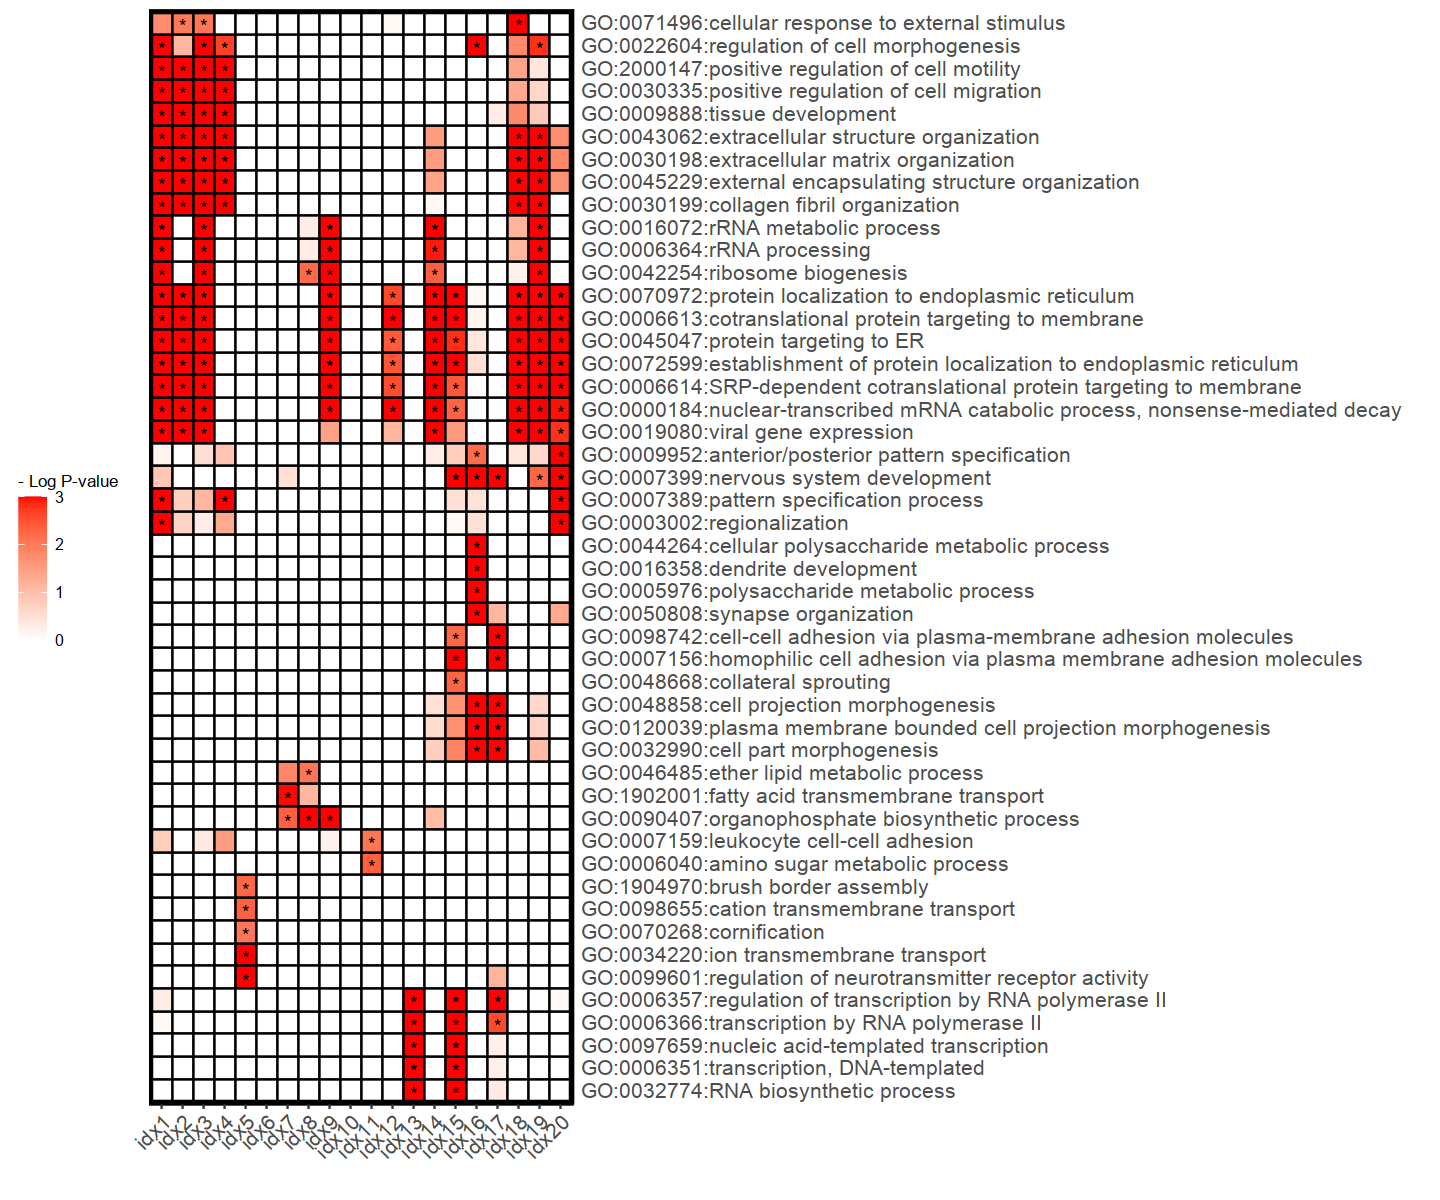

In [528]:
options(repr.plot.width = 12, repr.plot.height = 10)

gobp_plot

In [530]:
ggsave(sprintf("./subfigs/%s_GOBP_grid_ENRICH_%.3f_TERM_SIZE_MIN_%d_MAX_%d_INTERSECT_SIZE_MIN_%d_TOP_BY_PVAL_%d_ENRICH_%d_PVAL_CUTOFF_%.3f.pdf",
               format(Sys.Date(), "%Y%m%d"),
              ENRICH_CUTOFF, 
               TERM_SIZE_MIN,
              TERM_SIZE_MAX, INTERSECT_SIZE_MIN, TOP_BY_PVAL, TOP_BY_ENRICH, PVAL_CUTOFF), height=10, width=12)

### REAC Matrix

In [516]:
# make a list of REAC terms using cutoffs

ENRICH_CUTOFF = 1.5
TERM_SIZE_MAX = 5000
TERM_SIZE_MIN = 5
TOP_BY_PVAL = 10 # add top K by pval per peak set
TOP_BY_ENRICH = 10 # add top K by enrichment per peak set
PVAL_CUTOFF = 0.01
reac_terms = c()

for (i in seq(length(PEAK_SET_NAMES))) {
    filtered = gprof_res[[i]]$result
    filtered = filtered[filtered$significant==TRUE, ]
    filtered = filtered[filtered$source=="REAC", c(4,5,6,12, 9, 10,11,3, 15)]
    filtered = filtered[filtered$enrichment>ENRICH_CUTOFF, ]
    filtered = filtered[filtered$p_value<PVAL_CUTOFF, ]
    filtered = filtered[filtered$term_size<TERM_SIZE_MAX, ]
    filtered = filtered[filtered$term_size>=TERM_SIZE_MIN, ]
    filtered = filtered[unique(order(filtered$p_value)[1:TOP_BY_PVAL],
                              rev(order(filtered$enrichment))[1:TOP_BY_ENRICH]), ]
    
    reac_terms = unique(c(reac_terms, paste(filtered$term_id, filtered$term_name, sep=':')))
}

reac_terms = reac_terms[reac_terms!="NA:NA"]
length(reac_terms)

[1] 34

In [517]:
reac_terms[grep("stem", reac_terms, ignore.case=T)]
reac_terms[grep("fibro", reac_terms, ignore.case=T)]
reac_terms[grep("apop", reac_terms, ignore.case=T)]
reac_terms[grep("corni", reac_terms, ignore.case=T)]
reac_terms[grep("keratin", reac_terms, ignore.case=T)]

[1] "REAC:R-HSA-452723:Transcriptional regulation of pluripotent stem cells"

character(0)

character(0)

character(0)

character(0)

In [518]:
reac_matrix = make_term_peak_set_matrix(reac_terms, sources=c("REAC"))
reac_matrix_melted = make_melted_txp_matrix(reac_matrix, PEAK_SET_ORDER)
reac_plot = plot_melted_txp_matrix(reac_matrix_melted)

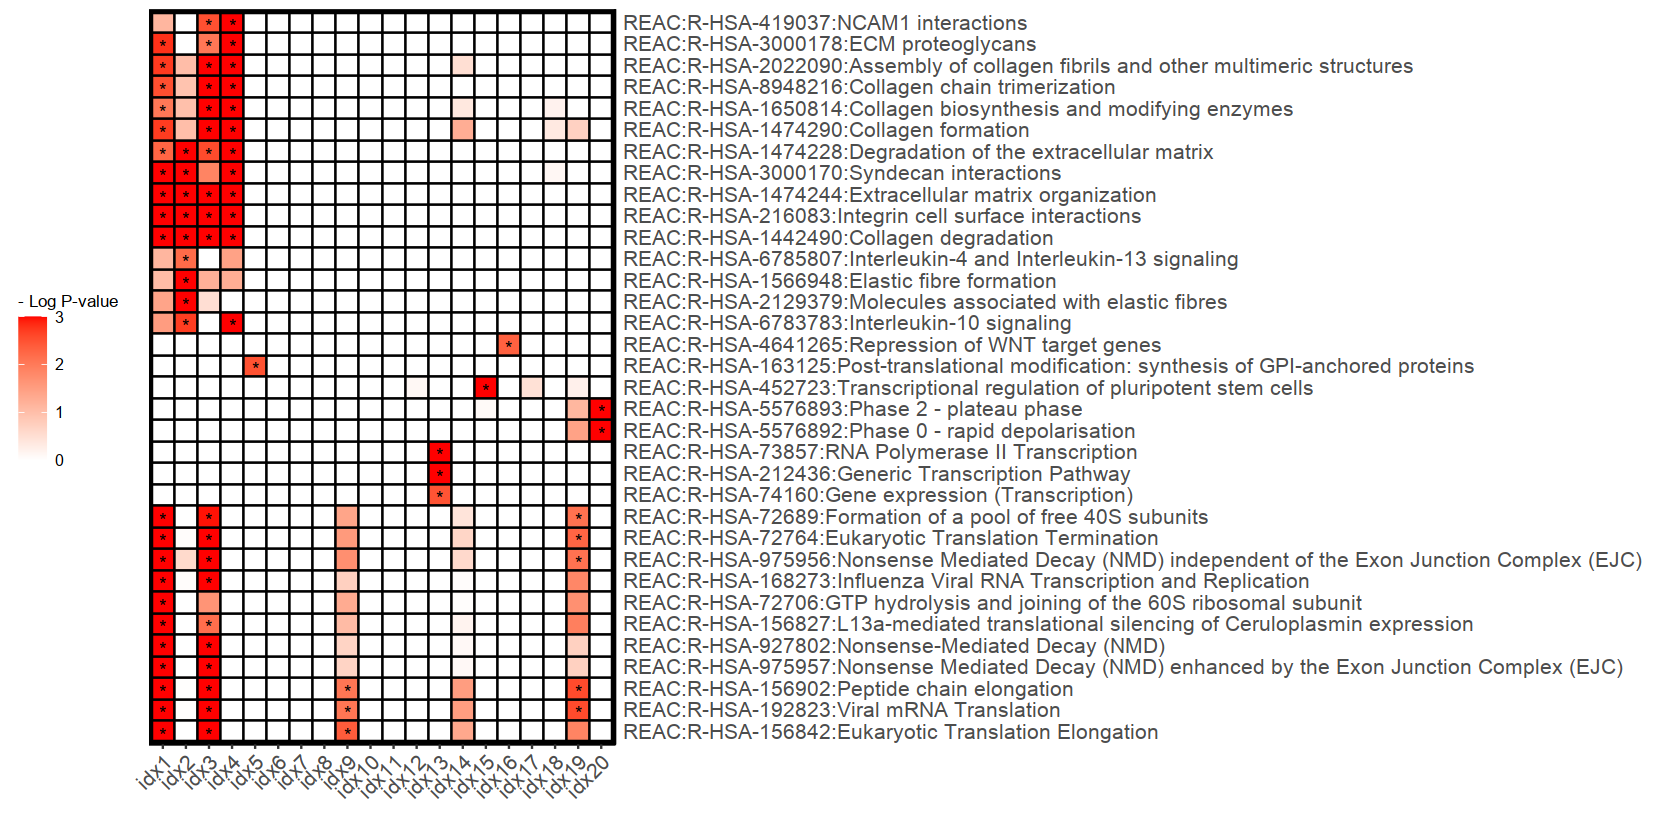

In [519]:
options(repr.plot.width = 14, repr.plot.height = 7)

reac_plot

In [522]:
ggsave(sprintf("./subfigs/%s_REAC_grid_ENRICH_%.3f_TERM_SIZE_MIN_%d_MAX_%d_INTERSECT_SIZE_MIN_%d_TOP_BY_PVAL_%d_ENRICH_%d_PVAL_CUTOFF_%.3f.pdf",
               format(Sys.Date(), "%Y%m%d"),
              ENRICH_CUTOFF, 
               TERM_SIZE_MIN,
              TERM_SIZE_MAX, INTERSECT_SIZE_MIN, TOP_BY_PVAL, TOP_BY_ENRICH, PVAL_CUTOFF), height=7, width=14)

## Gene Selection

In [338]:
tf_list = as.character(unlist(read.table("../../../resources//FANTOM5/tf.txt")$V1))

### Early Transient

In [401]:
early_transient = rev(sort(table(c(gene_lists[[6]],gene_lists[[7]],gene_lists[[8]]))))

In [402]:
early_transient["MAP2"]
early_transient["JAKMIP2"]

MAP2 
  13

JAKMIP2 
     12

### Mid Transient

In [403]:
mid_transient = rev(sort(table(c(gene_lists[[9]],gene_lists[[10]],gene_lists[[11]],gene_lists[[12]],gene_lists[[13]]))))

In [409]:
head(mid_transient , 20)


 ZNF486   ZNF90  ZNF682  ZNF138  TRIM61  ZNF680   NLRP7    F11R  TUBB4A  TNFSF9 
     34      33      28      27      26      24      24      24      23      22 
ST6GAL1   KDM4C  TRIM60   TNNI3   NLRP2   KHSRP  EPS8L1   EIPR1    SYT5  NUDT15 
     22      22      21      21      21      21      21      21      20      20 

In [424]:
mid_transient["DPPA5"]
mid_transient["DPPA2"]
mid_transient["DPPA3"]


DPPA5 
   10

DPPA2 
   19

DPPA3 
   11

### On

In [356]:
early_on = rev(sort(table(c(gene_lists[[14]],gene_lists[[15]]))))
length(early_on)

[1] 8118

In [357]:
late_on = rev(sort(table(c(gene_lists[[16]],gene_lists[[17]]))))
length(late_on)

[1] 3860

In [358]:
head(early_on, 40)


  GCNT2   L1TD1  ZNF701 ZSCAN10   THOC6  SEMA6A FAM124A  RIMKLB    LNPK  GPRC5C 
     33      31      30      29      29      28      28      27      27      26 
  CECR2  ADRA2C  PCDHB2   CLDN6  CACNG6   ABCA7  ZNF611    SPIB    RNH1  PCDHB5 
     26      26      25      25      25      25      24      24      24      23 
PCDHAC1   NANOG  ZNF578  ZNF486    WNK2   TDGF1 PCDHA12 PCDHA10   HDHD5    GRM4 
     23      23      22      22      22      22      22      22      22      22 
   GDF3  BICDL2    ADA2   ZNF90  ZNF808  ZNF682  TRIM71   TNNI3   RPL38   MCF2L 
     22      22      22      21      21      21      21      21      21      21 

In [371]:
early_on["GDF3"]

GDF3 
  22

In [359]:
head(late_on, 40)


  KLHDC7A  TMEM132D     SMOC2    IGSF21      KLK8     ADCY2    PCDHB2    RNF165 
       34        24        24        23        21        20        19        18 
  PCDHAC1      MYCN  C19orf81     GCNT2     DACT2    MYCNOS      COBL      BMP7 
       18        18        18        17        17        16        16        16 
     XACT   GALNT17     FOXA2    ELAVL2    BCL11B   PCDHA12     PDZD4    PCDHB5 
       15        15        15        15        15        14        13        13 
  PCDHA10     OLFM1     MYH14 LINC01405    JARID2     CCND2      TDRP     SNTG2 
       13        13        13        13        13        13        12        12 
   SHISA9      SDK2      RMST    RBFOX1    PHF21B    PCDHA4    NCAPG2      LHX1 
       12        12        12        12        12        12        12        12 

In [366]:
head(early_on[!names(early_on) %in% names(late_on)], 30)


    LNPK    NANOG     WNK2     GDF3  KREMEN2    CLDN9  SLC2A14  ST6GAL1 
      27       23       22       22       21       21       19       18 
   EIF3K    MXRA8    MMP25   KDELR2   COL9A3  BCL2L12   ZNF316     TRIR 
      18       17       17       17       17       17       16       16 
    TBCD     RRAS   PCOLCE  IER3IP1     FN3K  FLYWCH2 ARHGAP45   ZNF213 
      16       16       16       16       16       16       16       15 
    SDF4     PGLS   NLRP12     MUC4    KMT5C    IFT22 
      15       15       15       15       15       15 

In [361]:
head(late_on[!names(late_on) %in% names(early_on)], 30)


      TRPM3   CHRM3-AS2       CASP3        CCNQ      NKAIN1    C1orf226 
         10           9           8           7           6           6 
   TMEM170B      SH3GL3     PPP2R2B      NAP1L3    LRRC37A2     FAM133A 
          5           5           5           5           5           5 
     BCAP31       AUTS2       ANOS1      ZNF644        TRDN       RNF14 
          5           5           5           4           4           4 
     RIMKLA     LDLRAD4       KANK1        DTNB         DSP      DPYSL5 
          4           4           4           4           4           4 
      CENPU     ANKRD27      ZNF799 ZNF385D-AS1         VIM      TTC39C 
          4           4           3           3           3           3 

In [362]:
head(early_on[names(early_on) %in% tf_list], 50)


 ZNF701 ZSCAN10  ZNF611    SPIB   NANOG  ZNF578  ZNF486   ZNF90  ZNF808  ZNF682 
     30      29      24      24      23      22      22      21      21      21 
  FOXH1  ZNF761    OTX2  JARID2  ZNF600  ZNF581   ZNF28  ZNF253    UTF1   HOXB3 
     20      19      19      19      18      18      18      18      18      18 
   HEY2  ZNF331  PRDM14   HOXB7   HOXB4   FOXI3  ZNF316    ZIC5    ZIC2  BCL11B 
     18      17      17      17      17      17      16      16      16      16 
  ZNF93  ZNF880  ZNF845  ZNF765  ZNF525  ZNF213   ZFP42  TFAP2C   SOX13   HOXB6 
     15      15      15      15      15      15      15      15      15      15 
  HOXB5  ANKZF1  ZNF813  ZNF721  ZNF681  ZNF677  ZNF675  ZNF610  ZNF534  ZNF492 
     15      15      14      14      14      14      14      14      14      14 

In [363]:
head(late_on[names(late_on) %in% tf_list], 50)


  MYCN  FOXA2 BCL11B JARID2   LHX1  TERF1    SP8   CUX2 ZNF563 ZNF331 POU2F1 
    18     15     15     13     12     11     11     11     10     10     10 
  OTX2 ZNF423   TOX3 TCF7L1   SPIB  FOXB1 ZNF559  LMX1B ZNF813 ZNF667 ZNF525 
    10      9      9      9      9      9      8      8      7      7      7 
 ZMAT2   ZIC3  ZFHX2  TGIF2   SIX6  SALL3   PBX1   HMX1   AFF1 ZNF808 ZNF793 
     7      7      7      7      7      7      7      7      7      6      6 
ZNF675 ZNF607 ZNF334 ZNF121  ZMAT4   ZIC5  TSHZ2  TCF15  RCOR2 POU3F1 NKX1-2 
     6      6      6      6      6      6      6      6      6      6      6 
 KCMF1   IRX2   GBX2  ZNF91 ZNF816 ZNF761 
     6      6      6      5      5      5 

---

In [323]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] GO.db_3.10.0         org.Hs.eg.db_3.10.0  AnnotationDbi_1.48.0
 [4] IRanges_2.20.2       S4Vectors_0.24.4     Biobase_2.46.0      
 [7] BiocGenerics_0.32.0  scales_1.1.0         reshape2_1.4.4      
[10] patchwork_1.0.0      ggplot2_3.3.3        Matrix_1.2-18       
[13